## Synthetic data for supernovae compilations

#### In this notebook, we train an ANN with supernovae compitation.  In order to deal with the covariance matrix, we test two differents ways:

1) Add the statistical errors at the covariance matrix $\Sigma$ of the systematic errors of JLA and Pantheon supernovaes compilation. Then, we use the fact that $\Sigma$ is symmetrical and we can to use the spectral theorem: $\Sigma = P D P^T$

  and we add $D$ to the dataset to train a neural network as a feature instead the statistical error. 
  When we make predictions, we need to take a subspace of the original eigenvector matrix P and obtain a new covariance matrix.
  
 2) We don't use any properties of the matrix, only train ANN with z, $D_L$ and the statistical error. When we make predictions, we take any submatrix of the original covariance matrix.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers

### Read the covariance matrix for later

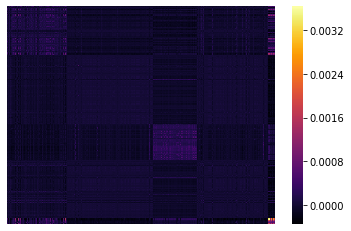

In [2]:
syscov = np.loadtxt('data/pantheon_errors.txt',skiprows=1).reshape((1048,1048))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
sns.heatmap(pd.DataFrame(syscov), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', robust=False, cbar=True)

### This matrix have sighly difference in the out diagonal elements, we fix it:

3


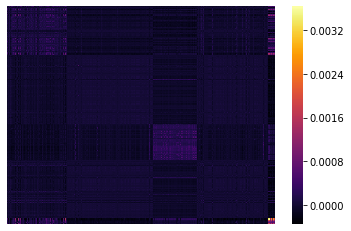

In [3]:
count = 0

for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
#             print(i,j)
#             print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]

print(count)
sns.heatmap(pd.DataFrame(syscov), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', robust=False, cbar=True)

### Now, load the data (redshift, $D_L$ and statistical errors)

In [4]:
file = 'data/pantheon.txt'
# file = 'data/jla_lcparams.txt'
data = pd.read_csv(file, sep = " " ,usecols=['zcmb', 'mb', 'dmb'] )
staterr = data.values[:,2]

### Generation of the data to feed the neural network.

#### We need z, $D_L$ and statistical error

In [5]:
X = data[['zcmb']].values
# scalerx = MinMaxScaler(feature_range=(-1,1))
# scalerx.fit(X.reshape(-1,1))
# X = scalerx.transform(X.reshape(-1,1))
# print(data[['mb']].values)

dl = np.reshape(data[['mb']].values, (len(X), 1))
# scalerdl = MinMaxScaler(feature_range=(-1,1))
# scalerdl.fit(dl.reshape(-1,1))
# dl = scalerdl.transform(dl.reshape(-1,1))


# Use err for method 2
err = np.reshape(data[['dmb']].values, (len(X), 1))

# scalereig = MinMaxScaler(feature_range=(-1,1))
# scalereig.fit(eigenval.reshape(-1,1))
# eigenval = scalereig.transform(eigenval.reshape(-1,1))

Y = np.concatenate((dl, err), axis=1)
print(np.shape(X), np.shape(Y))





(1048, 1) (1048, 2)


### Shuffle data and split in test and trainning set

In [6]:
shuffle = [x for x in range(len(X)) if x%2 ==1]
comp = [x for x in range(len(X)) if x%2 ==0]
shuffle.extend(comp)
split = 0.8

X = X[shuffle]
Y = Y[shuffle]

ntrain = int(split * len(X))
indx = [ntrain]
X_train, X_test = np.split(X, indx)
Y_train, Y_test = np.split(Y, indx)

### Define a model and some hyperparameters:

In [7]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0001,
                                   patience=100,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=2)]
# initializer = Constant(value=0.01)
initializer = tf.keras.initializers.RandomNormal() 

def model(input_x):
    efirst = Dense(300, activation='relu', input_shape=(1,))(input_x)
    ehidden = Dense(100, activation='relu')(efirst)
    ehidden2 = Dense(300, activation='relu')(ehidden)
    elast = Dense(2, activation='linear')(ehidden2)
    return elast

batch_size = 16
epochs = 100
input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 300)               600       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               30300     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 602       
Total params: 61,602
Trainable params: 61,602
Non-trainable params: 0
_________________________________________________________________


In [8]:
model_train = neural_model.fit(X_train, Y_train, batch_size=batch_size,
                               epochs=epochs, verbose=1,
                               validation_data=(X_test, Y_test),
                               callbacks=callbacks)

Epoch 1/100
53/53 [==============================] - 0s 7ms/step - loss: 138.6941 - val_loss: 28.8468
Epoch 2/100
53/53 [==============================] - 0s 3ms/step - loss: 8.6847 - val_loss: 7.2319
Epoch 3/100
53/53 [==============================] - 0s 3ms/step - loss: 3.1580 - val_loss: 3.5339
Epoch 4/100
53/53 [==============================] - 0s 3ms/step - loss: 1.5795 - val_loss: 2.4887
Epoch 5/100
53/53 [==============================] - 0s 3ms/step - loss: 0.9937 - val_loss: 1.8718
Epoch 6/100
53/53 [==============================] - 0s 2ms/step - loss: 0.7898 - val_loss: 1.6856
Epoch 7/100
53/53 [==============================] - 0s 2ms/step - loss: 0.7576 - val_loss: 1.6119
Epoch 8/100
53/53 [==============================] - 0s 2ms/step - loss: 0.7345 - val_loss: 1.6344
Epoch 9/100
53/53 [==============================] - 0s 2ms/step - loss: 0.7132 - val_loss: 1.6030
Epoch 10/100
53/53 [==============================] - 0s 2ms/step - loss: 0.6952 - val_loss: 1.5136
Epoch 

KeyboardInterrupt: 

In [ ]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('MSE = {}'.format(np.min(model_train.history['val_loss'])))
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_jla_method2.png", dpi=200)

In [ ]:
# ranz = np.random.uniform(0, 2, size=100)
ranz = np.linspace(0.01, 2.4, 500)
pred_random = neural_model.predict(ranz)
# pred_random
np.shape(pred_random[:, 1])

### Method 2: We need to choose a submatrix from the original and add the new statistical (fake) errors

In [ ]:
subspaceDim = len(ranz)
reduce_cov = syscov[:subspaceDim, :subspaceDim]
# reduce_cov += (pred_random[:, 1])**2
print(subspaceDim)

In [ ]:
sns.heatmap(reduce_cov, annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', robust=False, cbar=True)

plt.savefig("cov_method2.png")

In [ ]:
np.savetxt("pantheoncov_method2_nn500.txt", reduce_cov.reshape(500*500), delimiter= " ", header="#100 100")

In [ ]:
mookSN = np.concatenate((ranz.reshape(-1,1), pred_random), axis=1)
np.savetxt("pantheonDATA_method2_nn500.txt", mookSN, delimiter= " ", header="#z dm err")

In [ ]:
# plt.errorbar(X, dl, yerr=err)
plt.errorbar(data[['zcmb']].values, dl, err, fmt='g.', markersize=10, label='Observations', alpha=0.5)
plt.errorbar(ranz, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=10, label='Observations', alpha=0.5)